In [1]:
import os
import keras
from keras import *
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import matplotlib as mpl
from keras import optimizers
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import UpSampling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras import backend as K
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array
from skimage.io import imsave, imread
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy import ndimage
from scipy.misc import imresize
from keras.layers.convolutional import Deconv2D as Conv2DTranspose
from keras.models import Model
from keras.layers import Add
from keras.callbacks import ModelCheckpoint,TensorBoard
from keras.optimizers import Adam
from keras.models import Sequential
import sys
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras import callbacks
from sklearn.metrics import confusion_matrix
import itertools
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Input
from keras.layers import Input, merge, Dropout, Dense, Lambda, Flatten, Activation
from keras.layers.convolutional import MaxPooling2D, Convolution2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.preprocessing import image

from keras.models import Model
from keras import layers
from keras.layers import Dense
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import Conv2D
from keras.layers import SeparableConv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import GlobalMaxPooling2D
from keras.engine.topology import get_source_inputs
from keras.utils.data_utils import get_file
from keras import backend as K
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import _obtain_input_shape

from keras import backend as K
%matplotlib inline

np.random.seed(1337)

Using TensorFlow backend.


In [4]:
resize_h=256
resize_w=256

def load_data():
    total=len(os.listdir('melanoma/'))+len(os.listdir('others/'))
    imgs=[]
    imgs_mask=[]
    labels=[]
    i = 0
    images = os.listdir('melanoma/')
    for image_name in images:
        image_mask_name = image_name.split('.')[0]
        image_mask_name = image_mask_name+"_segmentation.png"
        img = ndimage.imread('melanoma/'+image_name)       
        img_mask = ndimage.imread('gt/'+image_mask_name)
        labels.append(1)
        img = img_to_array(img)
        img_mask=img_to_array(img_mask)
        img_mask=np.reshape(img_mask,(img_mask.shape[0],img_mask.shape[1],1))
        img = np.multiply(img ,img_mask/255.)
        img = imresize(img,(resize_h,resize_w))
        imgs.append(img)
        i += 1
    images = os.listdir('others/')
    for image_name in images:
        image_mask_name = image_name.split('.')[0]
        image_mask_name = image_mask_name+"_segmentation.png"
        img = ndimage.imread('others/'+image_name)       
        img_mask = ndimage.imread('gt/'+image_mask_name)
        labels.append(0)
        img = img_to_array(img)
        img_mask=img_to_array(img_mask)
        img_mask=np.reshape(img_mask,(img_mask.shape[0],img_mask.shape[1],1))
        img = np.multiply(img ,img_mask/255.)
        img = imresize(img,(resize_h,resize_w))
        imgs.append(img)
        i += 1
    print('Loading 2000 images done')
    imgs = np.array(imgs, dtype="float")
    imgs_mask = np.array(imgs_mask,dtype="float")
    labels = np.array(labels,dtype='float')
    return imgs, labels

X, Y = load_data()

Loading done 2000 images.


In [4]:
np.save( 'images.npy', X)
np.save('labels.npy', Y)

In [2]:
X = np.load('../imgs_classify.npy')
Y = np.load('../labels.npy')

In [6]:
Y[1]

1.0

In [7]:
np.unique(X)

array([  0.00000000e+00,   1.67186529e-16,   2.22915381e-16, ...,
         9.99998152e-01,   9.99998689e-01,   1.00000000e+00])

In [8]:
(trainX, testX, trainY, testY) = train_test_split(X,Y, test_size=0.20, random_state=42)

In [9]:
def f1_score(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [10]:
img_width, img_height = 256, 256
nb_train_samples = 1600
nb_validation_samples = 400
nb_filters1 = 32
nb_filters2 = 64
conv1_size = 3
conv2_size = 2
pool_size = 2
classes_num = 2
batch_size = 64
lr = 0.0002

In [11]:
model = Sequential()
model.add(Conv2D(nb_filters1, (conv1_size, conv1_size), padding="same", input_shape=(img_width, img_height, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Conv2D(nb_filters2, (conv2_size, conv2_size), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size), data_format='channels_first'))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy', f1_score, precision, recall])


In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 256, 256, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      8256      
_________________________________________________________________
activation_2 (Activation)    (None, 128, 128, 64)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 128, 64, 32)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 262144)            0         
__________

In [16]:
model_checkpoint1 = ModelCheckpoint('simple_classification1.hdf5',monitor = 'loss', verbose = 1,save_best_only=True)

In [17]:
classifier = model.fit(trainX,trainY, batch_size = 32, epochs = 50, verbose = True, validation_data = (testX, testY),callbacks=[TensorBoard(log_dir='/tmp/gated_cnn_autoencoder', histogram_freq=0,write_graph=True),model_checkpoint1],class_weight={0: 1, 1: 8})

Train on 1600 samples, validate on 400 samples
Epoch 1/50
1568/1600 [============================>.] - ETA: 2s - loss: 0.8936 - acc: 0.7487 - f1_score: 0.5626 - precision: 0.4266 - recall: 0.9082
Epoch 00001: loss improved from inf to 0.89969, saving model to simple_classification1.hdf5
1600/1600 [==============================] - 120s 75ms/step - loss: 0.8997 - acc: 0.7488 - f1_score: 0.5624 - precision: 0.4281 - recall: 0.9025 - val_loss: 0.5673 - val_acc: 0.7700 - val_f1_score: 0.5392 - val_precision: 0.4442 - val_recall: 0.7341
Epoch 2/50
1568/1600 [============================>.] - ETA: 2s - loss: 0.5681 - acc: 0.8769 - f1_score: nan - precision: 0.6197 - recall: 0.9193
Epoch 00002: loss improved from 0.89969 to 0.56406, saving model to simple_classification1.hdf5
1600/1600 [==============================] - 123s 77ms/step - loss: 0.5641 - acc: 0.8762 - f1_score: nan - precision: 0.6190 - recall: 0.9209 - val_loss: 0.5688 - val_acc: 0.7600 - val_f1_score: 0.5378 - val_precision: 0

KeyboardInterrupt: 

In [18]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,name = "Cf.png",
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    fig = plt.gcf()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    fig.savefig(name)
    plt.show()

In [19]:
classifier = model.predict(testX)

In [40]:
a = classifier>=0.6

In [41]:
cnf_matrix = confusion_matrix(a, testY)

In [42]:
class_names = ['Non-Melanoma', 'Melanoma']

Normalized confusion matrix
[[ 0.86  0.14]
 [ 0.42  0.58]]


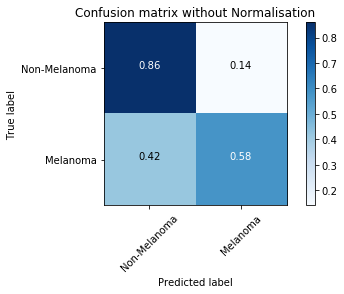

In [43]:
plot_confusion_matrix(cnf_matrix, classes=class_names,normalize= True,
                      name = "NB_Confusion_matrix_without_normalisation.png",
                      title='Confusion matrix without Normalisation')